# Modules

In [1]:
import urllib2
import xmltodict
import pandas as pd
from datetime import datetime 
import statsmodels.api as sm
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import requests
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 10

In [2]:
import wellapplication as wa
print(wa.__version__)

0.3.12


# Functions

In [3]:
def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const,r2

def regressRLM(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    return slope,const,r2

# Import Data

## Files

In [4]:
files = "M:/PROJECTS/Juab_Valley/Solinst Files/"

## Import Transducer Water Levels

In [ ]:
#import data
jun15 = wa.new_xle_imp(files+'06-12-2015.xle')
nov15 = wa.new_xle_imp(files+'11-12-2015.xle')
jun16 = wa.new_xle_imp(files+'F3-06 06-09-2016.xle')
dec16 = wa.new_xle_imp(files+'F3-06 12-13-2016.xle')
dfs = [jun15,nov15,jun16,dec16]

#fix jumps
for df in dfs:    
    df = wa.jumpfix(df,'Level',0.2)

#trim out of water data
nov15s = wa.dataendclean(nov15,'Level')
    

#combine datasets
wls = pd.concat([jun15,nov15s,jun16,dec16])
#resample
well_hr = wa.hourly_resample(wls)


In [ ]:
well_hr['Level'].plot()
plt.ylabel('transducer reading (ft water)')

## Import BaroLogger Data

In [ ]:
bjun15 = wa.new_xle_imp(files+'06-16-2015-baro.xle')
bdec16 = wa.new_xle_imp(files+'F3-06 baro 12-13-2016.xle')
bjun16 = wa.new_xle_imp(files+'F3-06 baro 06-09-2016.xle')
baro = pd.concat([bjun15,bjun16,bdec16])
baro_hr = wa.hourly_resample(baro)

In [ ]:
baro_hr.Level.plot()

In [ ]:
token = "1ab92e63dd924c6189e6d5e1015c2645"
station = 'KU14'
html = 'https://api.synopticlabs.org/v2/stations/timeseries?token={:}&stid={:}\
&state=ut&start={:%Y%m%d}0000&end={:%Y%m%d%H%M}&units=pres|mb,precip|in&output=csv'.format(token,station,well_hr.index[0],well_hr.index[-1])
mesobaro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_in'])

mesobaro_hr = wa.hourly_resample(mesobaro).shift(-6)
mesobaro_hr['baro_ft'] = mesobaro_hr['pressure_pascals']*0.000334562

In [ ]:
baros = pd.merge(mesobaro_hr,baro_hr,left_index=True,right_index=True,how='left')

baros.drop(['MeasuredLevel','Temperature','name','precip_in','pressure_pascals'],inplace=True,axis=1)
baroslim = baros.dropna()
m,b,r2 = scatterColor(baroslim['baro_ft'],baroslim['Level'],baroslim.index.to_julian_date())

baros['modeld_bp'] = baros['baro_ft'].apply(lambda x: m*x + b)

def fillB(x):
    if np.isnan(x[0]):
        return x[1]
    else:
        return x[0]
    
baros['Barometer'] = baros[['Level','modeld_bp']].apply(lambda x: fillB(x),1)

In [ ]:
baros['BaroInt'] = baros['Barometer'].interpolate(how='time')
#baros['BaroInt'].plot()
WellBaro = pd.merge(well_hr,baros,right_index=True,left_index=True,how='left')
WellBaro = WellBaro.drop(['name','Level_y','Temperature','MeasuredLevel'],axis=1)


In [ ]:
WellBaro_slim = WellBaro.dropna()
days = pd.date_range(start= WellBaro_slim.index[0],end= WellBaro_slim.index[-1],frequency='2D')
slp = []
inter = []
for i in range(len(days)-1):
    subst = WellBaro_slim[(WellBaro_slim.index > days[i]) & (WellBaro_slim.index < days[i+1])]
    if len(subst) > 0:
        try:
            m, b, r2 = regressRLM(subst.BaroInt,subst.Level_x,subst.index.to_julian_date())
            if r2 > 0.85:
                slp.append(m)
                inter.append(b)
        except:
            pass
slpmed = np.median(slp)
intermed = np.median(inter)
print(slpmed,intermed)


In [ ]:
WellBaro['adjwl'] = WellBaro['Level_x'] - WellBaro['BaroInt']
WellBaro['corrwl'] = WellBaro[['Level_x','BaroInt']].apply(lambda x: x[0] - (x[1]*slpmed + intermed),1)
WellBaro['corrwl'].plot()

In [ ]:
manual = pd.read_excel(files+'F3-06 WLs.xlsx','F3-06',index_col=2)

In [ ]:
wa.rollmeandiff(manual,'Elev',WellBaro,'corrwl',win=10)

In [ ]:
WellBaro['wl_elev'] = WellBaro['corrwl'] + 5150.712

In [ ]:
import matplotlib
SIZE = 14
x1 = WellBaro.index
x2 = manual.index
y1 = WellBaro.wl_elev
y2 = manual.Elev
rcParams['figure.figsize'] = 15, 10
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)


plt.figure()

plt.plot(x1,y1,color='blue',zorder=0)
plt.scatter(x2,y2,color='red',zorder=1)


date_rng = pd.date_range('2/1/2015', periods=23, freq='1M',closed='left',normalize=True)

#date_range = date_rng.map(lambda t: t.strftime('%Y-%m-%d'))
date_labs = date_rng.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_rng,date_labs,rotation=90)
plt.xlim(date_rng[0],date_rng[-1])
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.grid()
plt.ylabel('Groundwater Elevation (ft)')
plt.savefig('U:\GWP\Juab Valley\Solinst Files\graph.pdf')



In [ ]:
beg

In [ ]:
WellBaro.to_csv("U:\GWP\Juab Valley\Solinst Files\output.csv")

# USGS

In [13]:
import matplotlib

In [5]:
figplace= 'U:/GWP/Juab Valley/Paul/'
fileplace='U:/GWP/Juab Valley/Paul/'

In [6]:
#1602020101
#1603000502
box = [-111.94,39.35,-111.78,39.9]

In [7]:
HUCName = {16020203:'Provo'}

allsites,alldata = wa.get_nwis(box, selectType='gw_bbox')
siteList = list(allsites.site_no.unique())
allsites.to_csv(fileplace+'usgs_well_locals.csv')
alldata.reset_index(inplace=True)
print('{:} measurements from {:} sites imported!'.format(len(alldata), len(allsites)))

7654 measurements from 305 sites imported!


In [8]:
for site in siteList:
    mean = alldata.ix[alldata.site_no==site, 'value'].mean()
    std = alldata.ix[alldata.site_no==site, 'value'].std()
    alldata.ix[alldata.site_no==site, 'avgDiffWL'] = alldata.ix[alldata.site_no==site, 'value'] - mean
    alldata.ix[alldata.site_no==site, 'stdWL'] = alldata.ix[alldata.site_no==site, 'avgDiffWL']/std


In [9]:
alldata.reset_index(inplace=True)
alldata['datetime'] = pd.to_datetime(alldata['datetime'])
alldata.set_index(['datetime'],inplace=True)

In [10]:
#alldata.drop(['index'], axis=1, inplace=True)
alldata['year'] = alldata.index.year
alldata['month'] = alldata.index.month
alldata['doy'] = alldata.index.dayofyear
alldata['julian'] = alldata.index.to_julian_date()    

In [11]:
balldata = alldata.reset_index()
balldata.drop_duplicates(subset = ['site_no','datetime'], inplace=True)
provopivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'stdWL').sort_index()
pivdataAll = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value')
pivdataAll.sort_index(inplace=True)
pivdata = pivdataAll.resample('A').mean()

Data Loaded 
Type .ganttPlotter() after your defined object to make plot
Type .sitestats after your defined object to get summary stats
Data Loaded 
Type .ganttPlotter() after your defined object to make plot
Type .sitestats after your defined object to get summary stats
136
Data Loaded 
Type .ganttPlotter() after your defined object to make plot
Type .sitestats after your defined object to get summary stats


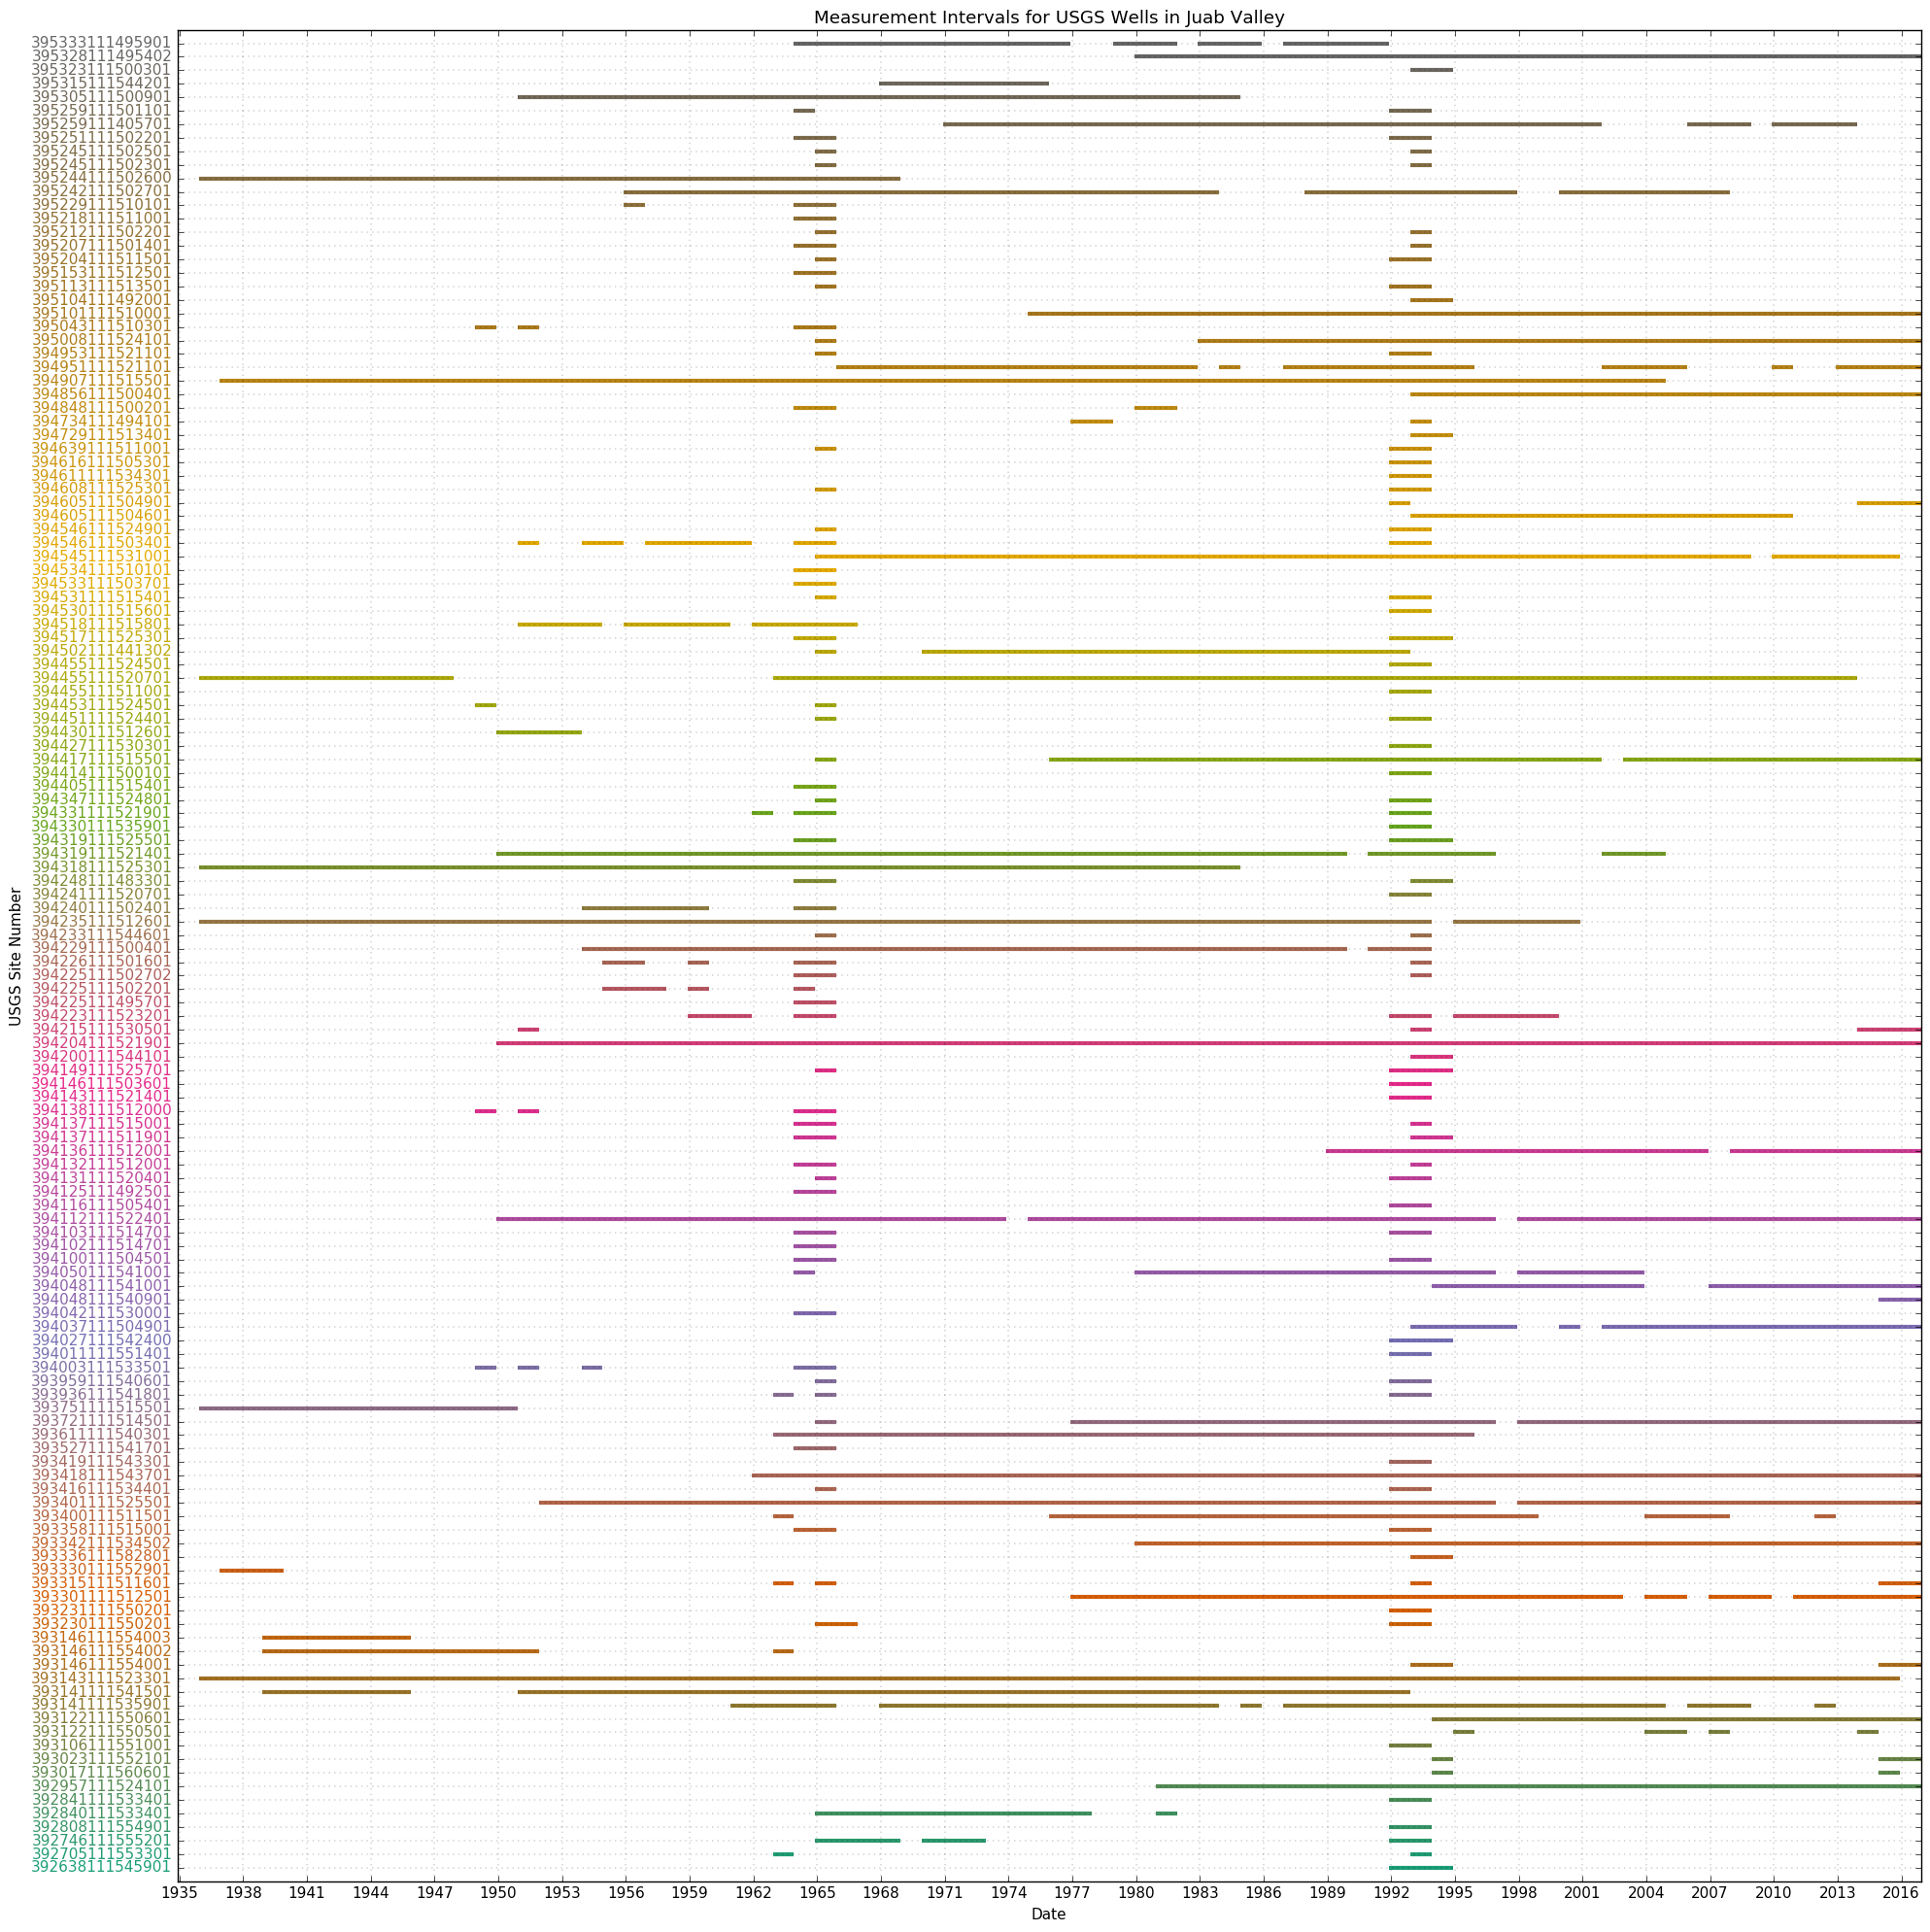

In [20]:
SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

gntAll = wa.gantt(pivdataAll)
infoAll = gntAll.sitestats #summary statistics for original data
gnt = wa.gantt(pivdata)
info = gnt.sitestats #summary statistics for annual data
infoless = info[info['count']>=3] #select only sites having more than 4 years of data; non-consecutive, one sample per year
provolist = list(infoless.StationId.values)
df = alldata[alldata['site_no'].isin(provolist)]
print(len(provolist))
gntshort = wa.gantt(pivdata, provolist)
numsites = len(gntshort.sitestats)
rcParams['figure.figsize'] = 20, 20
gntshort.ganttPlotter() #plot data
plt.ylabel('USGS Site Number')
plt.xlim(pd.datetime(1935,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1935-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_range)
plt.title('Measurement Intervals for USGS Wells in Juab Valley')
plt.tight_layout()

plt.savefig(figplace+'JuabGantt_long.pdf')

In [ ]:
dataXY = pd.merge(infoAll, allsites, right_on='site_no', left_on='StationId', how='left')
dataXY['WL_Elev'] = dataXY[['median','Elev']].apply(lambda x: x[1]*3.2808-x[0],1)

df2PntFt(dataXY,'UTM_X','UTM_Y',shpplace,'USGS_Provo_Lev','MapData.gdb',26912)

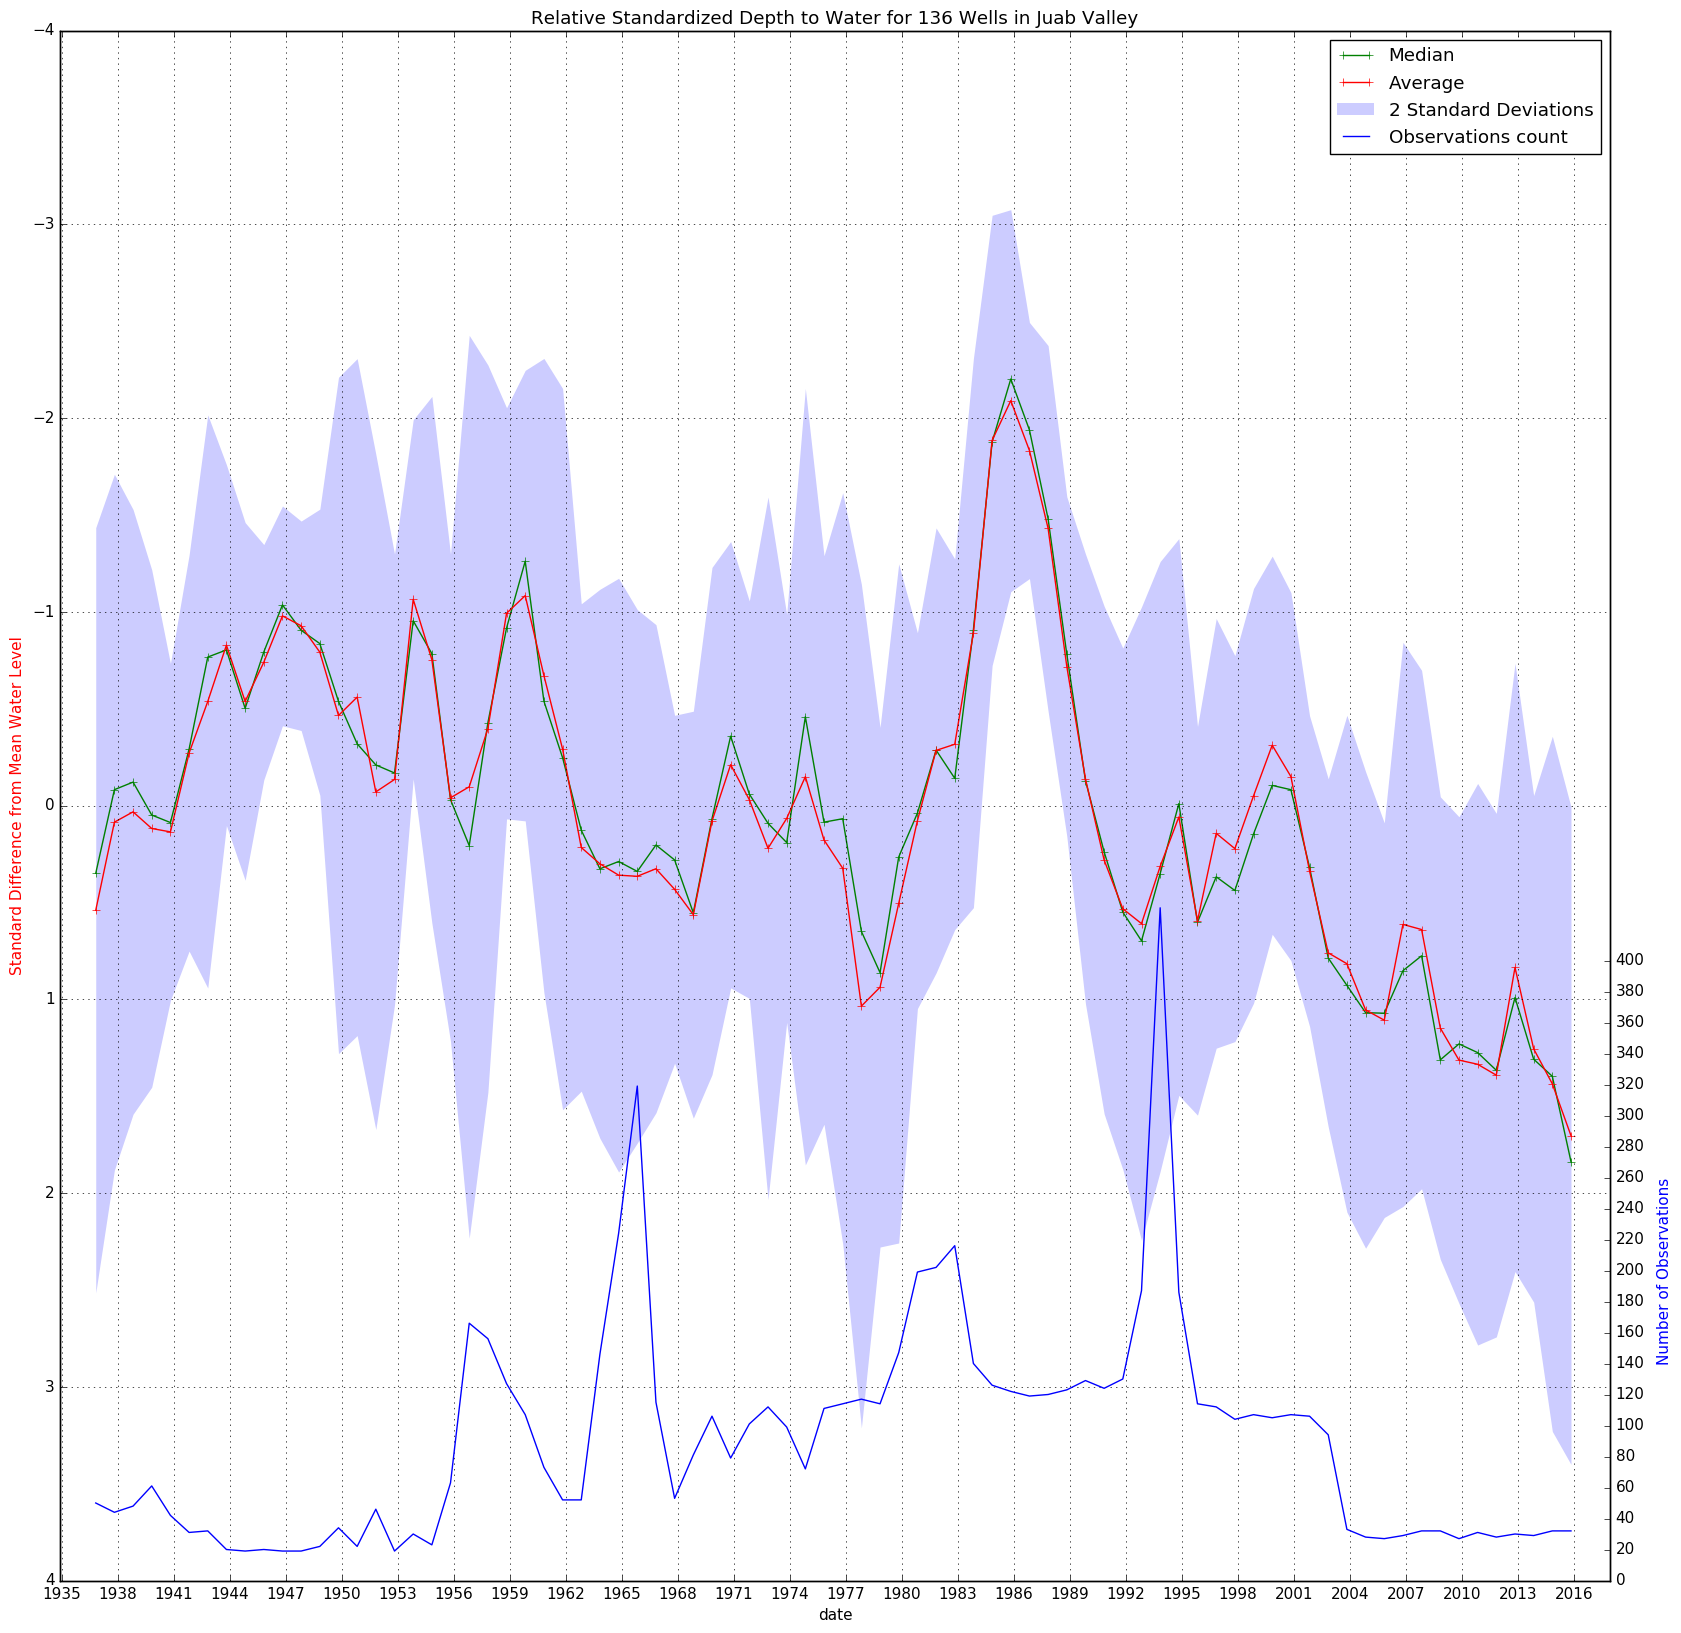

In [38]:
grp = pd.TimeGrouper("12M")
data = 'stdWL'#'avgDiffWL'#'diff'#'std_dWL'
title = 'Standard Difference from Mean Water Level'
wid = 4
cen = True

def confintpls(x):
    return np.mean(x)+(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

def confintmin(x):
    return np.mean(x)-(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

df = alldata[alldata['site_no'].isin(provolist)]

grpd = df.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

x2 = grpd.index[2:-2]
y2 = grpd['mean'][2:-2]
y3 = grpd['median'][2:-2]
snakegrp = grpd.median().to_frame()

SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x2, y3, '+-', color = 'green', label = 'Median' )
ax.plot(x2, y2, '+-', color = 'red', label = 'Average' )
ax.fill_between(x2,grpd['confmin'][2:-2],grpd['confpls'][2:-2],alpha=0.2,label='2 Standard Deviations',linewidth=0)

#ax1.set_ylim(3.5,-3.5)
ax.set_ylabel(title, color='red')
ax.invert_yaxis()
ax.grid()
ax2 = ax.twinx()
ax2.plot(x2,grpd['count'][2:-2],label='Observations count')
ax2.set_ylim(0,1000)
ax2.set_yticks(range(0,420,20))
ax2.set_ylabel('Number of Observations',color='blue')
ax2.yaxis.set_label_coords(1.03,0.2)
ax.set_xlim(pd.datetime(1935,1,1),pd.datetime(2018,1,1))
date_range = pd.date_range('1935-01-01', '2018-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax.set_xticks(date_range)
ax.set_xlabel('date')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Relative Standardized Depth to Water for {:} Wells in Juab Valley'.format(len(provolist)))
plt.savefig(figplace+'Juab_USGS_avg_stdev.pdf')

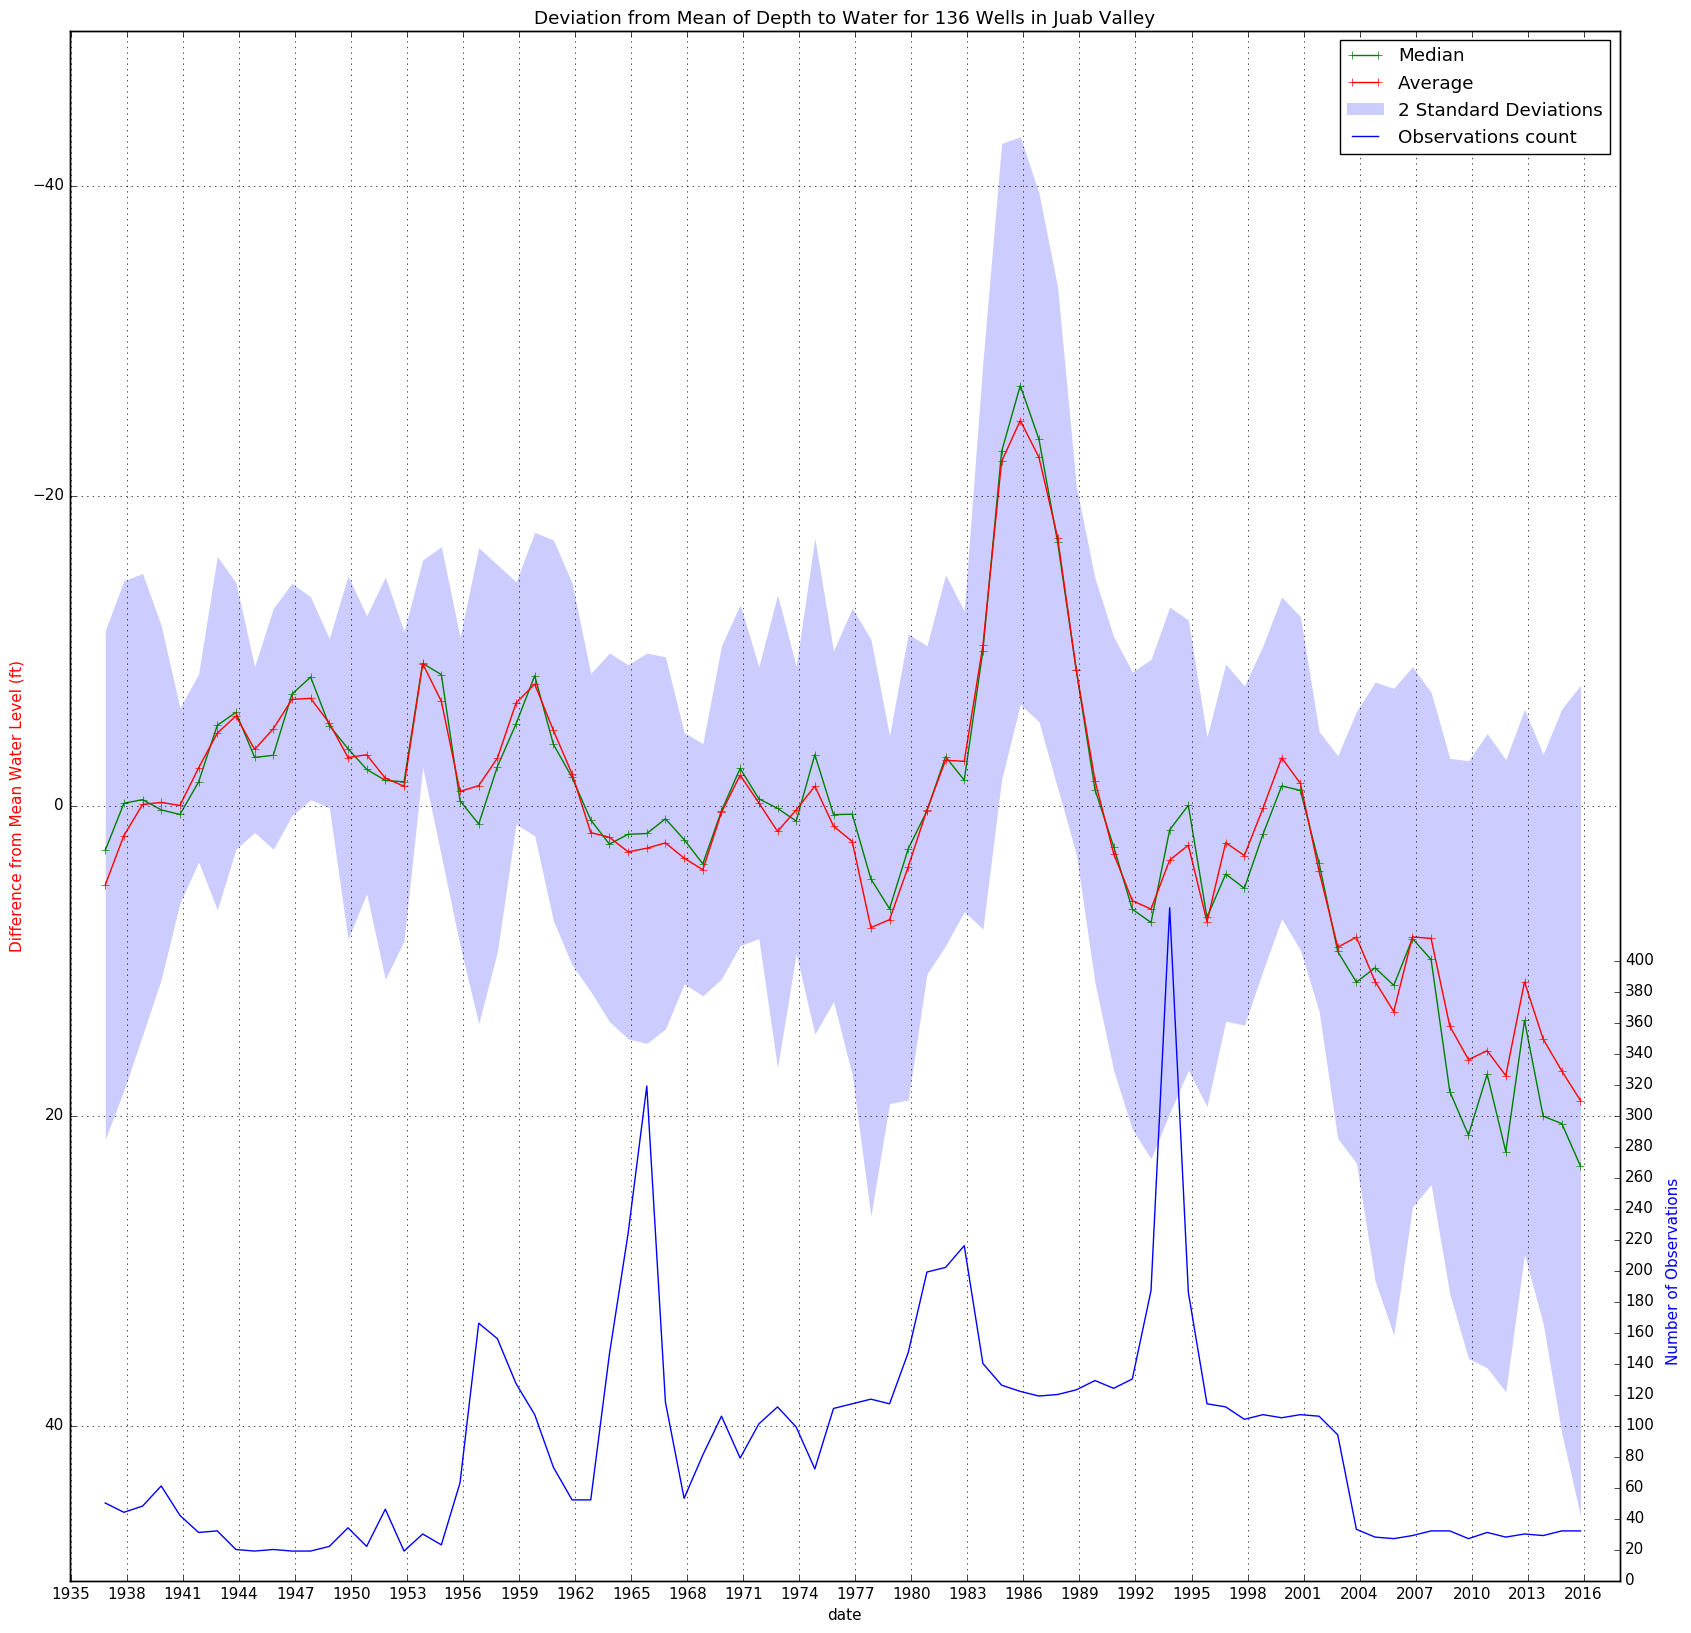

In [39]:
grp = pd.TimeGrouper("12M")
data = 'avgDiffWL'#'diff'#'std_dWL'
title = 'Difference from Mean Water Level (ft)'
wid = 4
cen = True

def confintpls(x):
    return np.mean(x)+(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

def confintmin(x):
    return np.mean(x)-(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

df = alldata[alldata['site_no'].isin(provolist)]

grpd = df.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

x2 = grpd.index[2:-2]
y2 = grpd['mean'][2:-2]
y3 = grpd['median'][2:-2]
snakegrp = grpd.median().to_frame()

SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x2, y3, '+-', color = 'green', label = 'Median' )
ax.plot(x2, y2, '+-', color = 'red', label = 'Average' )
ax.fill_between(x2,grpd['confmin'][2:-2],grpd['confpls'][2:-2],alpha=0.2,label='2 Standard Deviations',linewidth=0)

#ax1.set_ylim(3.5,-3.5)
ax.set_ylabel(title, color='red')
ax.invert_yaxis()
ax.grid()
ax2 = ax.twinx()
ax2.plot(x2,grpd['count'][2:-2],label='Observations count')
ax2.set_ylim(0,1000)
ax2.set_yticks(range(0,420,20))
ax2.set_ylabel('Number of Observations',color='blue')
ax2.yaxis.set_label_coords(1.03,0.2)
ax.set_xlim(pd.datetime(1935,1,1),pd.datetime(2018,1,1))
date_range = pd.date_range('1935-01-01', '2018-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax.set_xticks(date_range)
ax.set_xlabel('date')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Deviation from Mean of Depth to Water for {:} Wells in Juab Valley'.format(len(provolist)))
plt.savefig(figplace+'Juab_USGS_dev_avg.pdf')